In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

In [33]:
def spherical_to_cartesian(ds, lon, lat):
        """
        Convert coordinate system in DataSet to Cartesian

        Parameters
        ----------
        ds : xarray.Dataset
            Input dataset containing the data variables.
        lon, lat : str
            Names of the longitude and latitude dimensions in ds

        Returns
        -------
        aor_cart : xarray.Dataset
        """
        R = 6371e3  # Earth radius (m)

        lats = np.deg2rad(ds[lat])
        lons = np.deg2rad(ds[lon])

        # Broadcast to 2D
        lat2d, lon2d = xr.broadcast(lats, lons)

        r = R * np.cos(lat2d)
        x = r * np.cos(lon2d)
        y = r * np.sin(lon2d)

        ds_cart = ds.assign_coords(
            x=((lat, lon), x.data),
            y=((lat, lon), y.data),
        )

        return ds_cart

In [46]:
year = "2007"
ds = xr.open_dataset("cmems_mod_arc_phy_my_topaz4_P1M_vxo-vyo_180.00W-179.88E_50.00N-90.00N_0.00-4000.00m_1991-01-01-2025-08-01.nc")
lon = ds["longitude"]
lat = ds["latitude"]    # 1D lat (Northern Hemisphere example)

lon2d, lat2d = np.meshgrid(lon, lat)

u =  ds["vxo"].sel(time=year).isel(depth=0).mean("time").compute()  # zonal (east-west)
v =  ds["vyo"].sel(time=year).isel(depth=0).mean("time").compute()   # meridional (north-south)

speed = np.sqrt(u**2 + v**2)
speed_filled = np.nan_to_num(speed, nan=0.0)

u_filled = np.nan_to_num(u, nan=0.0)
v_filled = np.nan_to_num(v, nan=0.0)

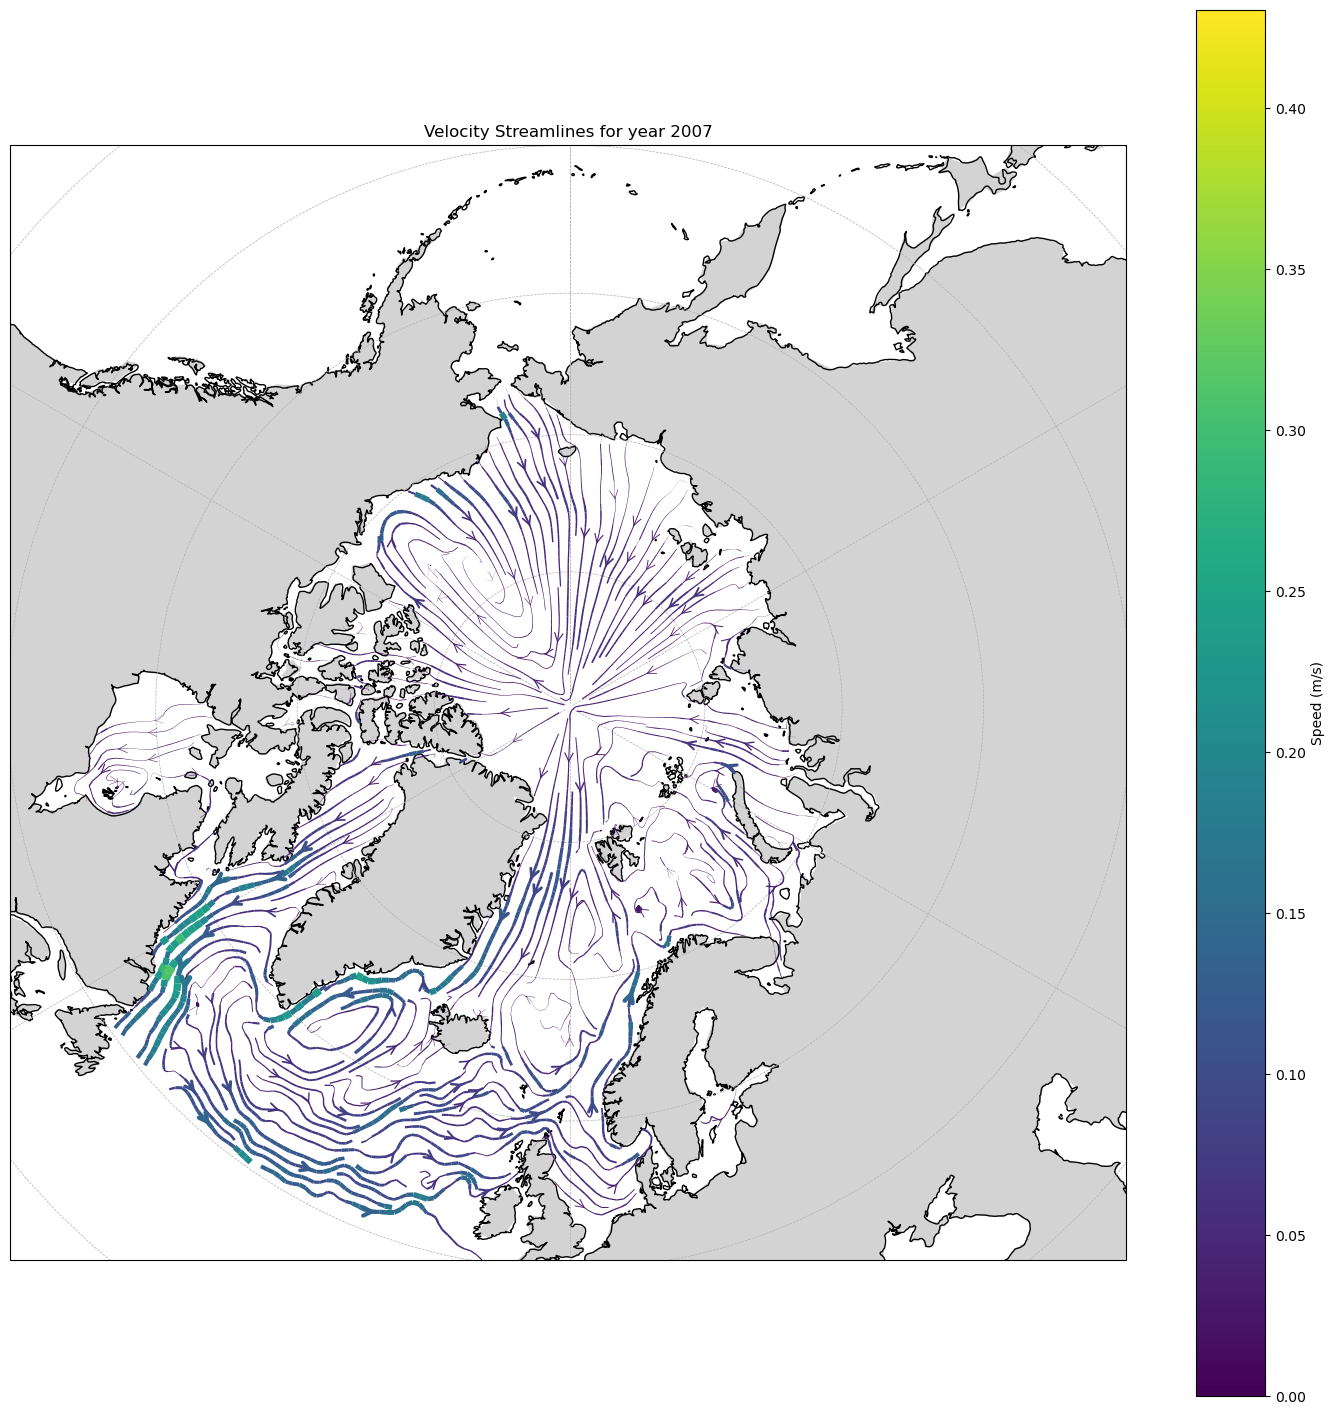

In [51]:

# --------------------------------------------------
# Plot
# --------------------------------------------------
proj_map = ccrs.NorthPolarStereo()
proj_data = ccrs.PlateCarree()  # because u/v are on lat-lon grid

fig = plt.figure(figsize=(18, 18))
ax = plt.axes(projection=proj_map)
#
# # Focus on Arctic (change for Antarctic)
ax.set_extent([-180, 180, 50, 90], crs=proj_data)

ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='--')

# Optional: thinner lines where flow is weak
lw = 10 * speed_filled / speed_filled.max()

strm = ax.streamplot(
    lon2d, lat2d,
    u_filled, v_filled,          # use filled or masked data
    density=5,
    color=speed_filled,                 # used for line coloring
    cmap='viridis',
    linewidth=lw,
    arrowstyle='->',
    arrowsize=1.5,
    transform=proj_data
)

cbar = plt.colorbar(strm.lines, ax=ax, pad=0.05)
cbar.set_label("Speed (m/s)")

plt.title(f"Velocity Streamlines for year {year}")
plt.show()
